# Air Quality in Houston - Step 2: Exploratory Data Analysis#


 The datasets have been cleaned up as much as possible in the Data Wrangling notebook. Now is time to get into the core characteristics of these datasets, explore relationships between data and define reliable features for subsequent modelling.
 First, let's import modules and saved dataframes (which can be found under '00_SavedDataframes').

In [1]:
### Import libraries
import numpy as np
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sst
import geopandas as gpd
import json
import copy
from collections import defaultdict,OrderedDict, namedtuple
from sklearn.preprocessing import PowerTransformer

### Location of dataframes and mapping files
path_header='C:\\Users\\Anne\\Documents\\GIT\\TheFoxerine\\'
path_df='CP2_AQ_HOUSTON\\00_SavedDataframes\\'
path_saf='CP2_AQ_HOUSTON\\00_OriginalData\\00_StuffAndThings\\'

There are 15 excel files to load and of course as many dataframes to name. To facilitate the loading, naming and easy utilisation of the dataframes, a dictionary of dataframes 'dico_df'  is created using the module glob and the module copy. dico_df stores the name of the dataframe as key and the dataframe as value (dico_df {dataframe_name: dataframe}) and locally defines and assigns the correct name to the dataframe using the method globals(). 

In [2]:
### Create a dictionary of dataframe so that I know where to find
### the material I need without having to endlessly scroll up and down.

### empty dictionary that will contain filenames and dataframes ###
dico_df = {}

### glob fetches all xls files in the folder ###
allfiles = glob.glob(path_header+path_df + '*.xlsx')

### Because Python is all about dictionaries ;) ###
for filename in allfiles:
    df = pd.read_excel(filename,index_col=0)
    filename=filename[74::]
    filename_len=len(filename)
    filename=filename[0:(filename_len-5)]
    key_name = str(filename)    
    dico_df[key_name] = copy.deepcopy(df)

### dico_df is ready
### the key is the name of the df
### the value is the df itself
print(dico_df.keys())


dict_keys(['epa', 'epa_co', 'epa_no2', 'epa_ozone', 'epa_pb', 'epa_pm10', 'epa_pm25', 'epa_so2', 'meteo_simple', 'riopa_indoor', 'riopa_outdoor', 'riopa_slim', 'stations_all', 'stations_epa', 'stations_epatamis', 'stations_meteo', 'stations_tamis', 'tamis_co', 'tamis_no2', 'tamis_ozone', 'tamis_pb', 'tamis_pm10', 'tamis_pm25', 'tamis_so2'])


In [3]:
### Let's unwrap all df with the correct name
for k,v in dico_df.items():
    globals()[f'{k}'] =v
    
### Let's look at one df, epa_co
epa_co.head()

,date,co_8hr_source,co_8hr_poc,site_id,co_8hr_max,co_8hr_units,site_name,co_8hr_obs_count,site_lat,site_lon
0,2008-01-01,AQS,1,482010024,0.2,ppm,Houston Aldine,19,29.901036,-95.326137
1,2008-01-02,AQS,1,482010024,0.3,ppm,Houston Aldine,24,29.901036,-95.326137
2,2008-01-03,AQS,1,482010024,0.3,ppm,Houston Aldine,24,29.901036,-95.326137
3,2008-01-04,AQS,1,482010024,0.2,ppm,Houston Aldine,24,29.901036,-95.326137
4,2008-01-05,AQS,1,482010024,0.3,ppm,Houston Aldine,24,29.901036,-95.326137


## 1. Indoor vs. Outdoor (RIOPA) ##
The RIOPA data is being used in this project to attempt to model indoor air from outdoor air data and additional category such as landuse, temperature...etc..

### 1.1. The Data: ###
The indoor and outdoor data are saved in the dataframes 'riopa_indoor' and riopa_outdoor', respectively. The outdoor data lacks 'land use' and 'location' information because it was not provided with the original report for outdoor data and the linkid of outdoor data is different from the one for indoor data. I need this information to plot the outdoor data and later to be able to connect this outdoor data to the EPA and TECQ/Tamis data.
As the outdoor sampling was done close to the home where the indoor sampling was performed, I will just add the land use, location longitude, location latitude, census block code and geoid number from the indoor data to the outdoor data.
There is a little trick in the linkid: the linkid of indoor data ends by '10' whereas the linkid of the outdoor data ends by '20'. The 6 first digits of the linkid is the link between outdoor and indoor entries. Consequently, I will merge land use and location information from the riopa_indoor dataset to the riopa_outdoor dataset on a 6 digit linkid.

In [4]:
riopa_indoor.head()

,linkid,sampleid,homeid,airtype,pm25,date_start_pm25,date_end_pm25,date,landuse_class,ambient_temp_c,ambient_rh,airexrate,temp_dry,dew_point,temp_wet,rh,census_group_block_code,home_lat,home_long
0,TX103110,10951,EX103,INDOOR,15.2,2000-10-17,2000-10-19,2000-10-17,deciduous forest,21.1000,0.0000,0.176838,69.283667,60.049633,63.702133,75.858133,4.820125e+11,29.787702,-95.096897
3,TX104110,10889,EX104,INDOOR,13.0,2000-09-26,2000-09-28,2000-09-26,high intensity residential,18.3300,0.0000,2.384460,66.305533,51.388900,57.777800,63.458333,4.820125e+11,NaN,NaN
7,TX106110,10965,EX106,INDOOR,9.3,2000-11-09,2000-11-11,2000-11-09,"pasture, hay",0.0000,0.0000,0.000000,51.127667,43.808500,47.539033,78.886533,4.820125e+11,NaN,NaN
10,TX104210,10986,EX204,INDOOR,17.2,2000-12-15,2000-12-17,2000-12-15,high intensity residential,19.4908,49.3269,2.465370,52.046667,36.953333,45.780000,61.353333,4.820125e+11,NaN,NaN
14,TX106210,10982,EX206,INDOOR,11.6,2001-01-15,2001-01-17,2001-01-15,"pasture, hay",0.0000,0.0000,1.713790,52.573567,49.035600,50.758567,89.278933,4.820125e+11,NaN,NaN


In [5]:
riopa_indoor.shape

(120, 19)

In [6]:
riopa_outdoor.shape

(126, 19)

In [7]:
riopa_indoor.linkid.unique()

array(['TX103110', 'TX104110', 'TX106110', 'TX104210', 'TX106210',
       'TX001110', 'TX002110', 'TX004110', 'TX005110', 'TX006110',
       'TX007110', 'TX008110', 'TX009110', 'TX010110', 'TX011110',
       'TX012110', 'TX013110', 'TX014110', 'TX015110', 'TX016110',
       'TX017110', 'TX018110', 'TX020110', 'TX021110', 'TX022110',
       'TX023110', 'TX024110', 'TX025110', 'TX026110', 'TX027110',
       'TX028110', 'TX029110', 'TX030110', 'TX032110', 'TX033110',
       'TX034110', 'TX035110', 'TX036110', 'TX037110', 'TX038110',
       'TX039110', 'TX040110', 'TX041110', 'TX042110', 'TX043110',
       'TX044110', 'TX045110', 'TX046110', 'TX047110', 'TX048110',
       'TX049110', 'TX050110', 'TX051110', 'TX052110', 'TX054110',
       'TX055110', 'TX056110', 'TX057110', 'TX058110', 'TX059110',
       'TX063110', 'TX064110', 'TX072110', 'TX073110', 'TX074110',
       'TX076110', 'TX092110', 'TX001210', 'TX002210', 'TX003210',
       'TX004210', 'TX005210', 'TX006210', 'TX008210', 'TX0092

In [8]:
riopa_outdoor.linkid.unique()

array(['TX103120', 'TX104120', 'TX106120', 'TX104220', 'TX001120',
       'TX002120', 'TX003120', 'TX004120', 'TX005120', 'TX006120',
       'TX007120', 'TX009120', 'TX010120', 'TX011120', 'TX012120',
       'TX013120', 'TX014120', 'TX015120', 'TX016120', 'TX017120',
       'TX018120', 'TX019120', 'TX020120', 'TX021120', 'TX022120',
       'TX023120', 'TX024120', 'TX025120', 'TX026120', 'TX027120',
       'TX028120', 'TX029120', 'TX030120', 'TX031120', 'TX032120',
       'TX033120', 'TX034120', 'TX035120', 'TX036120', 'TX037120',
       'TX038120', 'TX039120', 'TX040120', 'TX041120', 'TX042120',
       'TX043120', 'TX044120', 'TX045120', 'TX046120', 'TX047120',
       'TX048120', 'TX049120', 'TX050120', 'TX051120', 'TX052120',
       'TX053120', 'TX055120', 'TX056120', 'TX057120', 'TX058120',
       'TX059120', 'TX063120', 'TX064120', 'TX072120', 'TX073120',
       'TX074120', 'TX076120', 'TX092120', 'TX001220', 'TX002220',
       'TX003220', 'TX004220', 'TX005220', 'TX006220', 'TX0072

In [9]:
### Drop excess information (additional date columns)
### Select the essential. I chose to subset instead of 
### dropping the columns so that I can quickly copy paste
### column names I would need later
riopa_interest=['date','linkid','sampleid','homeid','airtype',
                'pm25',
                'landuse_class','ambient_temp_c','ambient_rh','airexrate',
                'temp_dry','dew_point','temp_wet','rh',
                'census_group_block_code','home_lat','home_long']
indoor=riopa_indoor[riopa_interest]
outdoor=riopa_outdoor[riopa_interest]

### Drop landuse_class and location information
### in outdoor that contains only 'tbd' or 'nan'
outdoor.drop(['landuse_class','census_group_block_code','home_lat','home_long'],axis=1,inplace=True)

### Create the column common_id which is the first digit of linkid
indoor['common_id']=indoor['linkid'].str[:6]
outdoor['common_id']=outdoor['linkid'].str[:6]

### Get a subset of indoor containing the common_id, landuse and location information
foroutdoor=indoor[['common_id','landuse_class','census_group_block_code','home_lat','home_long']]

### Merge the subset to outdoor on common_id
outdoor2=pd.merge(outdoor, foroutdoor, on=['common_id'], how='left')

outdoor2.isnull().sum()

C:\Users\Anne\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

date                        0
linkid                      0
sampleid                    0
homeid                      0
airtype                     0
pm25                        0
ambient_temp_c              0
ambient_rh                  0
airexrate                   0
temp_dry                    1
dew_point                   1
temp_wet                    1
rh                          1
common_id                   0
landuse_class              11
census_group_block_code    12
home_lat                   93
home_long                  93
dtype: int64

We knew from data wrangling that the blockgroup numbers provided by the RIOPA team were mostly wrong, which explains the high nuber of null value for home_lat and home_lon. Missing land use class can be replaced by 'unknown'. For the indoor dataframe, there are 4 missing values related to outdoor temperature and rh and two missing blockgroup code. These are not important because they are not part of what the indoor data is defined by.

In [10]:
indoor.isnull().sum()

date                        0
linkid                      0
sampleid                    0
homeid                      0
airtype                     0
pm25                        0
landuse_class               0
ambient_temp_c              0
ambient_rh                  0
airexrate                   0
temp_dry                    4
dew_point                   4
temp_wet                    4
rh                          4
census_group_block_code     2
home_lat                   80
home_long                  80
common_id                   0
dtype: int64

In [11]:
outdoor2.head()

,date,linkid,sampleid,homeid,airtype,pm25,ambient_temp_c,ambient_rh,airexrate,temp_dry,dew_point,temp_wet,rh,common_id,landuse_class,census_group_block_code,home_lat,home_long
0,2000-10-17,TX103120,10886,EX103,OUTDOOR,17.8,21.4366,0.0000,0,69.277767,60.208333,63.791667,76.263867,TX1031,deciduous forest,4.820125e+11,29.787702,-95.096897
1,2000-09-26,TX104120,10888,EX104,OUTDOOR,13.4,19.0117,0.0000,0,66.402800,51.402767,57.826400,63.291667,TX1041,high intensity residential,4.820125e+11,NaN,NaN
2,2000-11-09,TX106120,10964,EX106,OUTDOOR,13.6,28.4035,0.0000,0,51.291700,43.597233,47.534700,78.055533,TX1061,"pasture, hay",4.820125e+11,NaN,NaN
3,2000-12-15,TX104220,10980,EX204,OUTDOOR,3.6,12.1109,66.0289,0,52.046667,36.953333,45.780000,61.353333,TX1042,high intensity residential,4.820125e+11,NaN,NaN
4,1999-06-23,TX001120,10001,TX001,OUTDOOR,9.3,27.0800,0.0000,0,80.732667,76.141533,77.472800,86.693867,TX0011,low intensity residential,4.820141e+11,29.696430,-95.443767


As shown below, the datasets are small: indoor contains 120 PM 2.5 measurements, which should be the target value; and outdoor2 contains 130 PM 2.5 measurements, which should be one of the predictor value. 
A quick note on terms, PM25 is a common pollutant. PM stands for "Particulate Matter". "2.5" is the size of the PM.

In [12]:
indoor.describe().T

,count,mean,std,min,25%,50%,75%,max
sampleid,120.0,1.052261e+04,2.985377e+02,1.000200e+04,1.025325e+04,1.054850e+04,1.081450e+04,1.107400e+04
pm25,120.0,1.681000e+01,1.239439e+01,3.000000e+00,8.850000e+00,1.340000e+01,2.245000e+01,7.890000e+01
ambient_temp_c,120.0,2.130935e+01,8.423788e+00,0.000000e+00,2.225705e+01,2.390000e+01,2.569658e+01,3.046000e+01
ambient_rh,120.0,3.217231e+01,2.691021e+01,0.000000e+00,0.000000e+00,4.541915e+01,5.556113e+01,8.024650e+01
airexrate,120.0,8.771877e-01,1.634181e+00,0.000000e+00,2.293085e-01,4.251540e-01,7.657250e-01,1.334320e+01
temp_dry,116.0,7.237497e+01,1.056974e+01,4.646530e+01,6.594874e+01,7.348658e+01,8.177164e+01,8.630923e+01
dew_point,116.0,6.289407e+01,1.149305e+01,2.623377e+01,5.801596e+01,6.622958e+01,7.246899e+01,7.614153e+01
temp_wet,116.0,6.654903e+01,1.003015e+01,3.827643e+01,6.139140e+01,6.859822e+01,7.494595e+01,7.806727e+01
rh,116.0,7.523376e+01,9.310597e+00,4.825850e+01,6.828262e+01,7.675163e+01,8.290520e+01,9.116327e+01
census_group_block_code,118.0,4.819578e+11,2.620982e+08,4.807171e+11,4.820125e+11,4.820125e+11,4.820125e+11,4.820141e+11


In [13]:
outdoor2.describe().T

,count,mean,std,min,25%,50%,75%,max
sampleid,130.0,1.052085e+04,2.889030e+02,1.000000e+04,1.027325e+04,1.055350e+04,1.077275e+04,1.099000e+04
pm25,130.0,1.461308e+01,5.613127e+00,3.600000e+00,1.070000e+01,1.315000e+01,1.757500e+01,3.400000e+01
ambient_temp_c,130.0,2.300133e+01,6.506294e+00,0.000000e+00,1.942647e+01,2.414975e+01,2.864270e+01,3.246880e+01
ambient_rh,130.0,4.583456e+01,3.846027e+01,0.000000e+00,0.000000e+00,6.367720e+01,8.087453e+01,1.039110e+02
airexrate,130.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
temp_dry,129.0,7.299080e+01,1.075929e+01,4.639717e+01,6.622980e+01,7.416480e+01,8.236110e+01,8.879447e+01
dew_point,129.0,6.321445e+01,1.159387e+01,2.645357e+01,5.869927e+01,6.683447e+01,7.230230e+01,7.614153e+01
temp_wet,129.0,6.694727e+01,1.011543e+01,3.841800e+01,6.231670e+01,6.959467e+01,7.522470e+01,7.808180e+01
rh,129.0,7.461600e+01,9.267294e+00,4.778780e+01,6.802127e+01,7.645703e+01,8.232290e+01,9.116327e+01
census_group_block_code,118.0,4.819358e+11,3.073614e+08,4.807171e+11,4.820125e+11,4.820125e+11,4.820125e+11,4.820141e+11


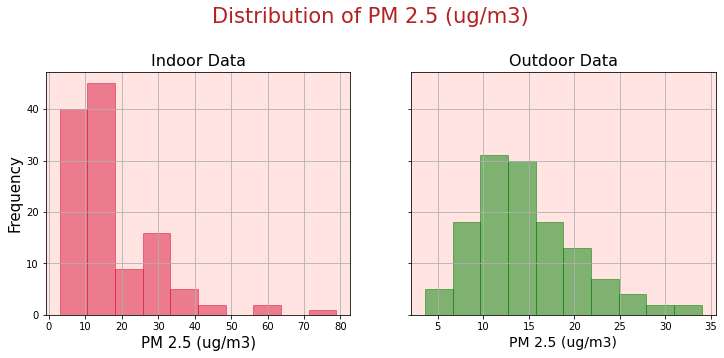

In [14]:
### Plot pm25 distribution indoor and outdoor
fig, (ind, out) = plt.subplots(1, 2, sharey=True, figsize=(12, 5), frameon=True)
fig.suptitle('Distribution of PM 2.5 (ug/m3)', fontsize=21, color='firebrick')
fig.subplots_adjust(top=0.8)

ind.hist(data=indoor, x='pm25', bins=10, alpha=0.5, facecolor='crimson', 
         linewidth=1, histtype='bar', ec='crimson')
ind.set_title('Indoor Data', fontsize=16)
ind.set(xlabel='PM 2.5 (ug/m3)', ylabel='Frequency')
ind.xaxis.get_label().set_fontsize(15)
ind.yaxis.get_label().set_fontsize(15)
ind.set_facecolor('mistyrose')
ind.grid(True)

out.hist(data=outdoor2, x='pm25', bins=10, alpha=0.5, facecolor='green', 
         linewidth=1, histtype='bar', ec='green')
out.set_title('Outdoor Data', fontsize=16)
out.set(xlabel='PM 2.5 (ug/m3)')
out.xaxis.get_label().set_fontsize(14)
out.set_facecolor('mistyrose')
out.grid(True)

plt.show()

The overall distribution of PM 2.5 is right-skewed for both indoor and outdoor datasets. Let's use a log on these.

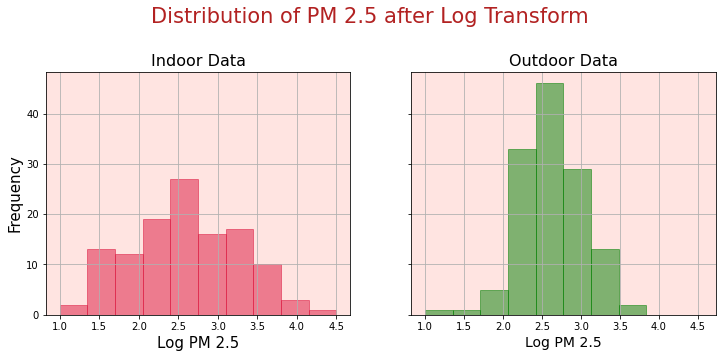

In [15]:
### Apply log transform on the column pm25
outdoor2['pm25_log']=np.log(outdoor2.pm25)
indoor['pm25_log']=np.log(indoor.pm25)

### Plot log(pm25) distribution indoor and outdoor
fig, (log_ind, log_out) = plt.subplots(1, 2, sharey=True, figsize=(12, 5), frameon=True)
fig.suptitle('Distribution of PM 2.5 after Log Transform', fontsize=21, color='firebrick')
fig.subplots_adjust(top=0.8)

log_ind.hist(data=indoor, x='pm25_log', bins=10, range=[1,4.5], alpha=0.5, facecolor='crimson', 
         linewidth=1, histtype='bar', ec='crimson')
log_ind.set_title('Indoor Data', fontsize=16)
log_ind.set(xlabel='Log PM 2.5', ylabel='Frequency')
log_ind.xaxis.get_label().set_fontsize(15)
log_ind.yaxis.get_label().set_fontsize(15)
log_ind.set_facecolor('mistyrose')
log_ind.grid(True)

log_out.hist(data=outdoor2, x='pm25_log', bins=10, range=[1,4.55], alpha=0.5, facecolor='green', 
         linewidth=1, histtype='bar', ec='green')
log_out.set_title('Outdoor Data', fontsize=16)
log_out.set(xlabel='Log PM 2.5')
log_out.xaxis.get_label().set_fontsize(14)
log_out.set_facecolor('mistyrose')
log_out.grid(True)

plt.show()

After log transformation both PM 2.5 distributions do look normal enough.The function 'stats.normaltest' is a scipy function which tests the null hypothesis that a sample comes from a normal distribution (p>0.001). The results of normaltest (below) confirm the log distributions are normal.

In [16]:
stat_ind, p_ind= sst.normaltest(indoor.pm25)
stat_out, p_out= sst.normaltest(outdoor2.pm25)
stat_indlog, p_indlog= sst.normaltest(indoor.pm25_log)
stat_outlog, p_outlog= sst.normaltest(outdoor2.pm25_log)
print('Normal test results indoor: s2+k2=', stat_ind,' and p=', p_ind)
print('Normal test results outdoor: s2+k2=', stat_out, ' and p=', p_out)
print('Normal test results indoor: s2+k2=', stat_indlog,' and p=', p_indlog)
print('Normal test results outdoor: s2+k2=', stat_outlog, ' and p=', p_outlog)

Normal test results indoor: s2+k2= 63.58730963685212  and p= 1.5566506338264703e-14
Normal test results outdoor: s2+k2= 22.29970378229126  and p= 1.4377416355008872e-05
Normal test results indoor: s2+k2= 1.3750304217882976  and p= 0.5028239295112038
Normal test results outdoor: s2+k2= 2.5825690383427276  and p= 0.2749174194913027


Outliers within the PM 2.5 or other pollutant concentrations are important data because they represent crisis events where concentrations go beyong healthy limits and therefore should be identified and counted. Boxplots are a good way to show outliers, median and mean.

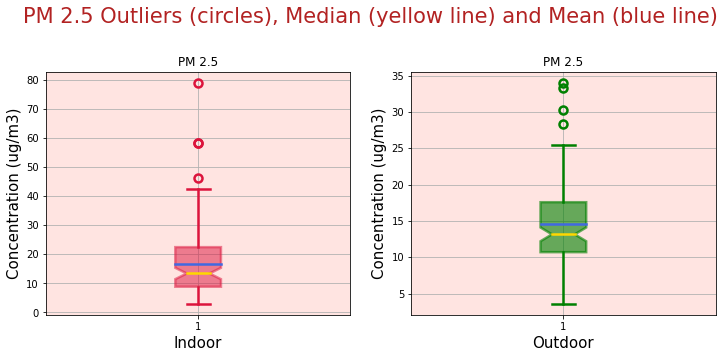

In [17]:
fig, (boxind, boxout)= plt.subplots(1, 2, figsize=(12, 5), frameon=True)
fig.suptitle('PM 2.5 Outliers (circles), Median (yellow line) and Mean (blue line)', size=21, color='firebrick')
fig.subplots_adjust(top=0.8)
### plt.boxplot(data,sym='',widths=0.75, patch_artist=True)

medianprops1 = dict(linestyle='-', linewidth=2.5, color='gold')
meanlineprops1 = dict(linestyle='-', linewidth=2.5, color='royalblue')

boxind.set_title('PM 2.5')
boxind.boxplot(indoor.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='crimson',color='crimson', alpha=0.5),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='crimson', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='crimson', linewidth=2.5),
               capprops=dict(color='crimson', linewidth=2.5))
boxind.set(xlabel='Indoor', ylabel='Concentration (ug/m3)')
boxind.xaxis.get_label().set_fontsize(15)
boxind.yaxis.get_label().set_fontsize(15)
boxind.set_facecolor('mistyrose')
boxind.grid(True)

boxout.boxplot(outdoor2.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='green',color='green', alpha=0.6),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='green', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='green', linewidth=2.5),
               capprops=dict(color='green',linewidth=2.5))
boxout.set(xlabel='PM 2.5', ylabel='Concentration (ug/m3)')
boxout.set_title('PM 2.5')
boxout.set(xlabel='Outdoor')
boxout.xaxis.get_label().set_fontsize(15)
boxout.yaxis.get_label().set_fontsize(15)
boxout.set_facecolor('mistyrose')
boxout.grid(True)

plt.show()

While the mean and median values of indoor (16.8 ug/m3, 13.4 ug/m3) and outdoor (14.6 ug/m3, 13.2 ug/m3) PM 2.5 concentrations are close, the indoor concentrations spread towards higher values (i.e. the end of 4th quartile at 42 ug/m3 with outliers up to 80 ug/m3) than the outdoor concentrations (i.e. remain below 35 ug/m3).

Going back to the Data Wrangling Notebook, I checked remarks and other measurement found in the original file PM_Mass.xlsx. The reasons behind the outliers are:

- The extreme indoor value at 78.9 ug/m3 is not associated with an outdoor value because the electricity went off as stated in the PM_Mass.xlsx ("the Harvard outdoor final flow not taken because electricity went off"). I choose to drop it from the indoor dataframe.
- The extreme indoor value at 58.2 ug/m3 has been measured from 04/10/2000 to 04/12/2000 in homeid TX047. Another measurement was taken from 04/12/2000 to 04/14/2000 which showed a value of 8 ug/m3 which is closer to the outdoor value of 6 ug/m3 measured during the same time period. I choose to drop the value 58.2.
- There is no reason to drop the extreme indoor value of 58.2 ug/m3 in homeid TX007. The associated outdoor value is 26 ug/m3. There was likely an indoor source of PM 2.5.
- Indoor outliers in the 40s are fine.

In [18]:
### removing selected outliers
cond1=indoor.pm25 != 78.9
cond2=indoor.pm25 != 58.2
indoor2=indoor[cond1 & cond2]
indoor2.shape

(117, 19)

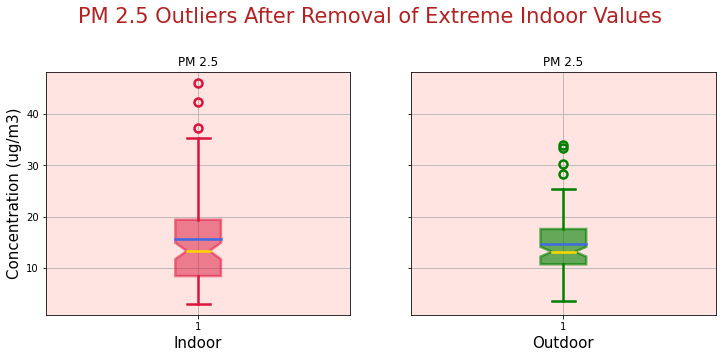

In [19]:
fig, (boxind2, boxout2)= plt.subplots(1, 2, figsize=(12, 5), sharey=True, frameon=True)
fig.suptitle('PM 2.5 Outliers After Removal of Extreme Indoor Values', size=21, color='firebrick')
fig.subplots_adjust(top=0.8)
### plt.boxplot(data,sym='',widths=0.75, patch_artist=True)

medianprops1 = dict(linestyle='-', linewidth=2.5, color='gold')
meanlineprops1 = dict(linestyle='-', linewidth=2.5, color='royalblue')

boxind2.set_title('PM 2.5')
boxind2.boxplot(indoor2.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='crimson',color='crimson', alpha=0.5),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='crimson', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='crimson', linewidth=2.5),
               capprops=dict(color='crimson', linewidth=2.5))
boxind2.set(xlabel='Indoor', ylabel='Concentration (ug/m3)')
boxind2.xaxis.get_label().set_fontsize(15)
boxind2.yaxis.get_label().set_fontsize(15)
boxind2.set_facecolor('mistyrose')
boxind2.grid(True)

boxout2.boxplot(outdoor2.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='green',color='green', alpha=0.6),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='green', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='green', linewidth=2.5),
               capprops=dict(color='green',linewidth=2.5))
boxout2.set(xlabel='PM 2.5')
boxout2.set_title('PM 2.5')
boxout2.set(xlabel='Outdoor')
boxout2.xaxis.get_label().set_fontsize(15)
boxout2.yaxis.get_label().set_fontsize(15)
boxout2.set_facecolor('mistyrose')
boxout2.grid(True)

plt.show()

Let's rename column in indoor2 and outdoor2 to prepare for a merge

Then we will have a quick look at outliers in the other columns by plotting other bocxplots. Replace zero of ambient temperature C and rh by the mean
and with dataframe.hist
and heat map

In [20]:
indoor2.columns

Index(['date', 'linkid', 'sampleid', 'homeid', 'airtype', 'pm25',
       'landuse_class', 'ambient_temp_c', 'ambient_rh', 'airexrate',
       'temp_dry', 'dew_point', 'temp_wet', 'rh', 'census_group_block_code',
       'home_lat', 'home_long', 'common_id', 'pm25_log'],
      dtype='object')

In [21]:
outdoor2.columns

Index(['date', 'linkid', 'sampleid', 'homeid', 'airtype', 'pm25',
       'ambient_temp_c', 'ambient_rh', 'airexrate', 'temp_dry', 'dew_point',
       'temp_wet', 'rh', 'common_id', 'landuse_class',
       'census_group_block_code', 'home_lat', 'home_long', 'pm25_log'],
      dtype='object')

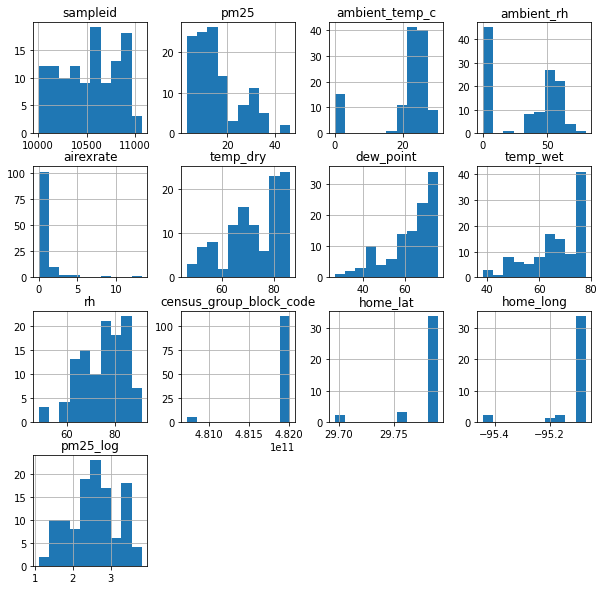

In [22]:
in2=indoor2.hist(bins=10, figsize=(10,10))

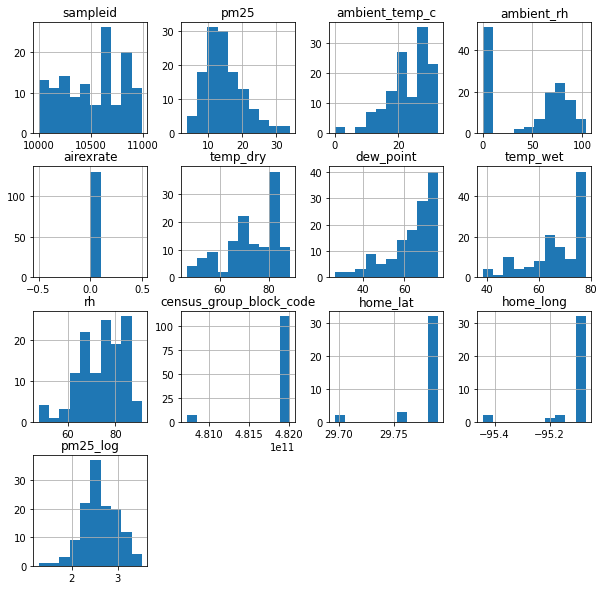

In [23]:
ou2=outdoor2.hist(bins=10, figsize=(10,10))

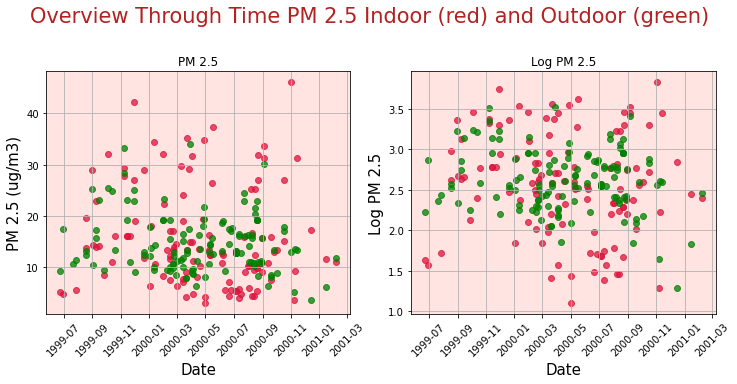

In [24]:
fig, (pl1, pl3)= plt.subplots(1, 2, sharex=True, figsize=(12, 5), frameon=True)
fig.suptitle('Overview Through Time PM 2.5 Indoor (red) and Outdoor (green)', size=21, color='firebrick')
fig.subplots_adjust(top=0.8)

#flierprops = dict(marker='o', markerfacecolor='dodgerblue', markersize=8,linestyle='none', markeredgecolor='darkblue')
pl1.set_title('PM 2.5')
pl1.scatter(indoor2.date,indoor2.pm25, color='crimson', alpha=0.75)
pl1.scatter(outdoor2.date,outdoor2.pm25, color='green', alpha=0.75)
pl1.set(xlabel='Date', ylabel='PM 2.5 (ug/m3)')
pl1.xaxis.get_label().set_fontsize(15)
pl1.yaxis.get_label().set_fontsize(15)
plt.setp(pl1.get_xticklabels(), rotation=45)
pl1.set_facecolor('mistyrose')
pl1.grid(True)

pl3.set_title('Log PM 2.5')
pl3.scatter(indoor2.date,indoor2.pm25_log, color='crimson', alpha=0.75)
pl3.scatter(outdoor2.date,outdoor2.pm25_log, color='green', alpha=0.75)
pl3.set(xlabel='Date', ylabel='Log PM 2.5')
pl3.xaxis.get_label().set_fontsize(15)
plt.setp(pl3.get_xticklabels(), rotation=45)
pl3.yaxis.get_label().set_fontsize(15)
pl3.set_facecolor('mistyrose')
pl3.grid(True)